# Lab Assignment One: Exploring Table Data

### Authors
- Juliana Antonio
- Xiaona Hang
- Chuanqi Deng


### 1. Business Understanding 

### 2. Data Preparation
#### 2.1. Read Images

In [4]:
from collections import defaultdict
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

In [64]:
images = defaultdict(list)
labels = defaultdict(list)
uniformed_size = (224,224)

for image_path in Path('data').rglob('*.jpg'):
    class_name = image_path.parent.stem
    train_test = image_path.parent.parent.stem
    img = cv2.resize(cv2.imread(str(image_path)),uniformed_size)
    images[train_test].append(img)
    labels[train_test].append(class_name)


train_imgs = np.concatenate([images['train']])
test_imgs = np.concatenate([images['test']])

# encode string lables to numeric labels
encoder = LabelEncoder()
encoder.fit(labels['test'])
test_labels = encoder.transform(labels['test'])
train_labels = encoder.transform(labels['train'])

print(f"Train: {train_imgs.shape}, Test: {test_imgs.shape}")

Train: (3352, 224, 224, 3), Test: (813, 224, 224, 3)


#### 2.2. Linearize

In [6]:
train_imgs = train_imgs.reshape((len(train_imgs), -1))
test_imgs = test_imgs.reshape((len(test_imgs), -1))
print(f"Train: {train_imgs.shape}, Test: {test_imgs.shape}")

Train: (3352, 150528), Test: (813, 150528)


#### 2.3. Visualization

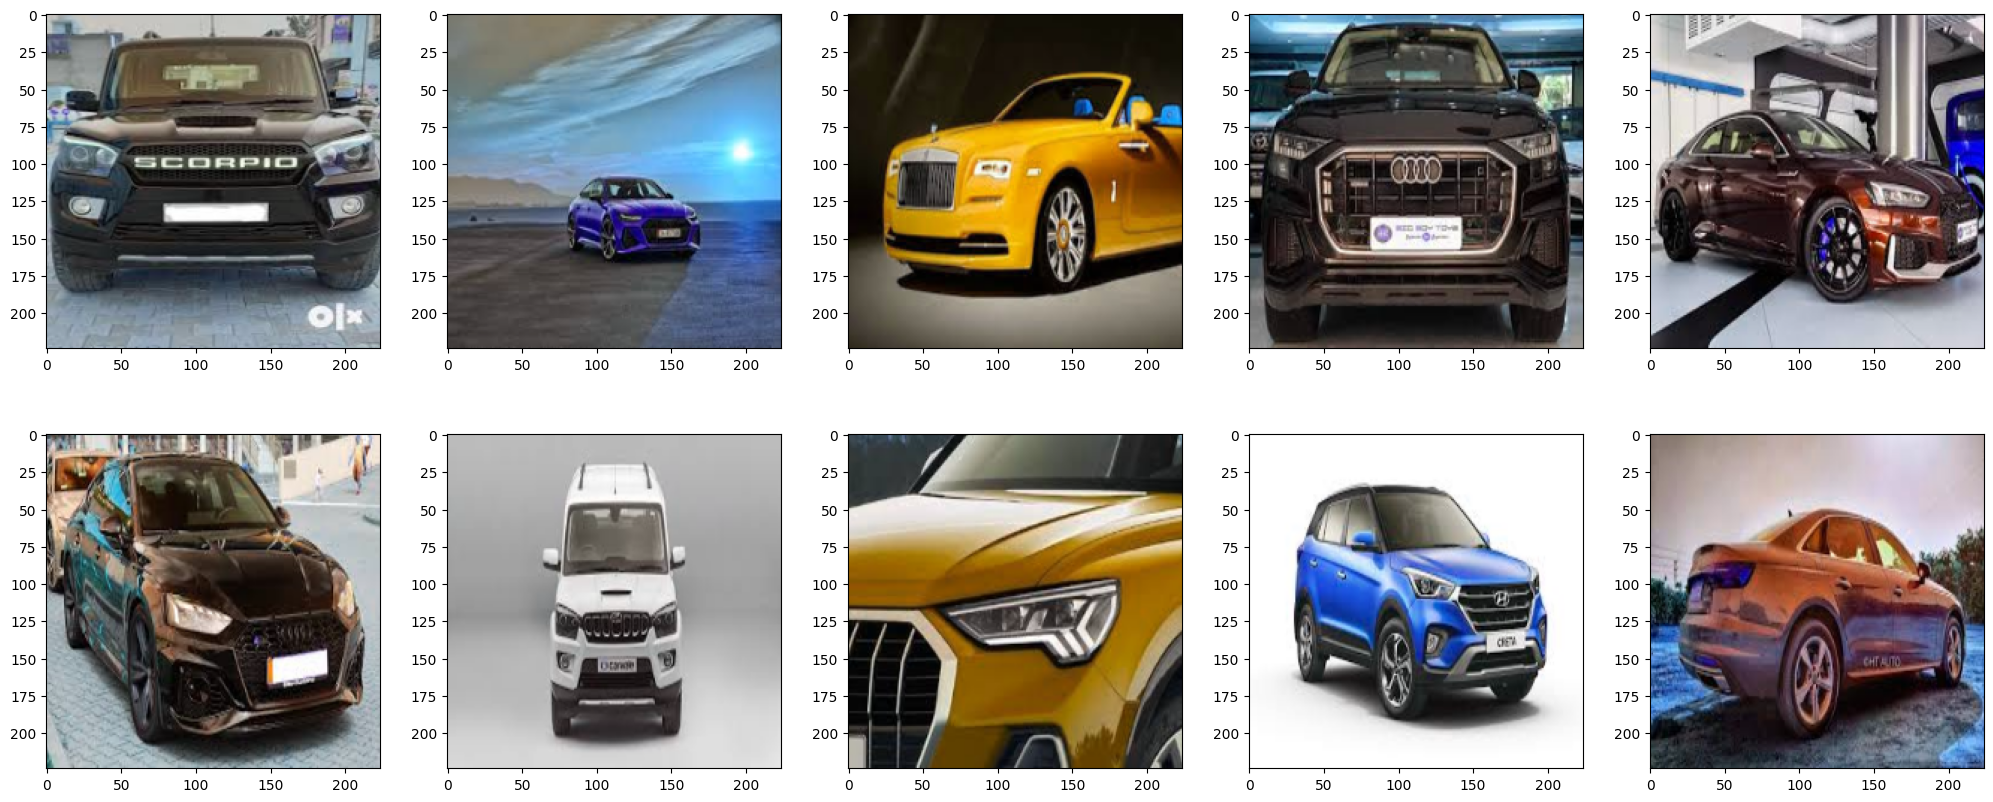

In [7]:
plt.figure(figsize=(25,10))
for i, r_idx in enumerate(np.random.randint(0, len(images['train']), 10)):
    ax = plt.subplot(2,5,i+1)
    ax.imshow(images['train'][r_idx])

### 3. Data Reduction

#### 3.1 PCA

In [45]:
def run_PCA_analysis(data, n_components=150, required_component_ratio = 0.8, randomized = False):
    # PCA
    pca = PCA(n_components, svd_solver="randomized" if randomized else "auto")
    pca_data = pca.fit_transform(data)
    
    # Analyze how many components are required to adequately represent the image data.
    accumulated_ratio = np.cumsum(pca.explained_variance_ratio_)
    ratio_idx = np.argmax(accumulated_ratio >= required_component_ratio)

    # ploting
    plt.figure(figsize=(20,5))
    plt.bar(range(1, n_components+1), pca.explained_variance_ratio_)
    plt.xticks(range(1, n_components+1, 3), rotation=70)
    plt.yticks(np.arange(0, 0.30, 0.01), [f"{x*100:.1f}%" for x in np.arange(0, 0.30, 0.01)])
    plt.xlim(0, n_components+1)

    ax = plt.twinx()
    ax.set_yticks(np.arange(0, 1.01, 0.05), [f"{x*100:.1f}%" for x in np.arange(0, 1.01, 0.05)])
    ax.set_ylim(0,1)
    ax.plot(range(1, n_components+1), accumulated_ratio, color='orange')
    ax.axvline(x=ratio_idx, color='red', linestyle='--')
    ax.axhline(y=required_component_ratio, color='red', linestyle='--')

    plt.title("explained variance of each components")
    return pca_data

CPU times: total: 58.3 s
Wall time: 11.3 s


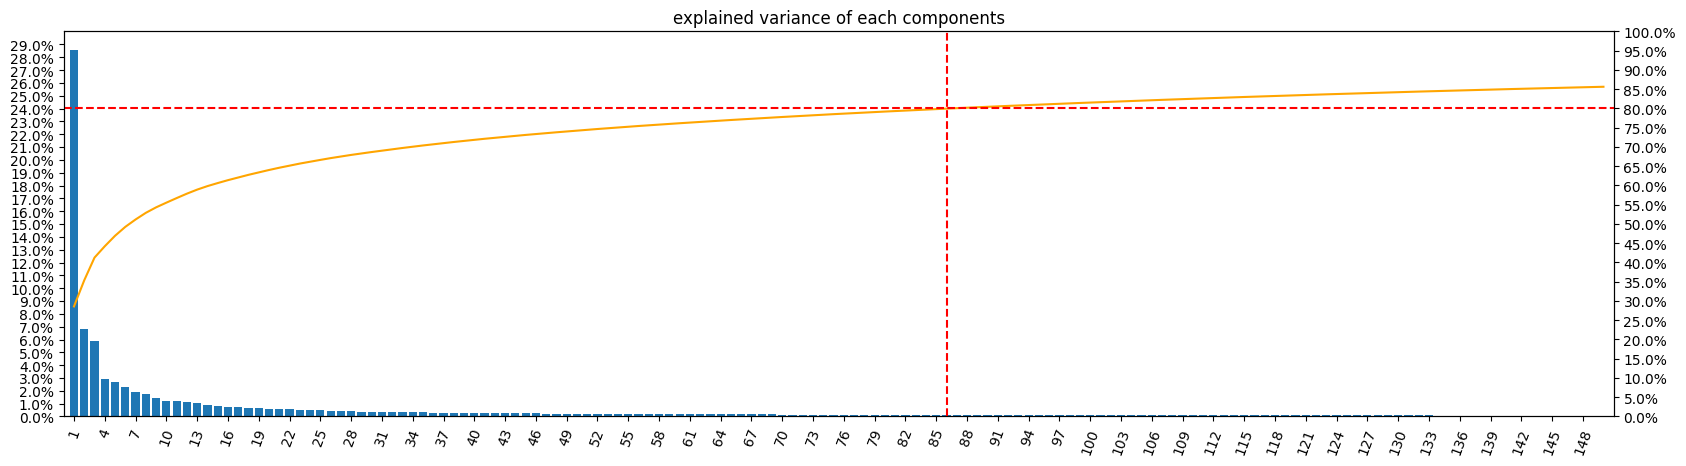

In [43]:
n_components = 150
required_component_ratio = 0.8
%time run_PCA_analysis(test_imgs, n_components, required_component_ratio);

The analysis above used PCA to deduct the image demension from 150528 to 150. And then the number of components that are required to adequately represent the image data is determined by a 0.8 threshold. As the red dotted lines shown above, it is clear that the first 112 principal components can adequately represent the images with given threshold.

#### 3.2 Random PCA

CPU times: total: 58.1 s
Wall time: 9.97 s


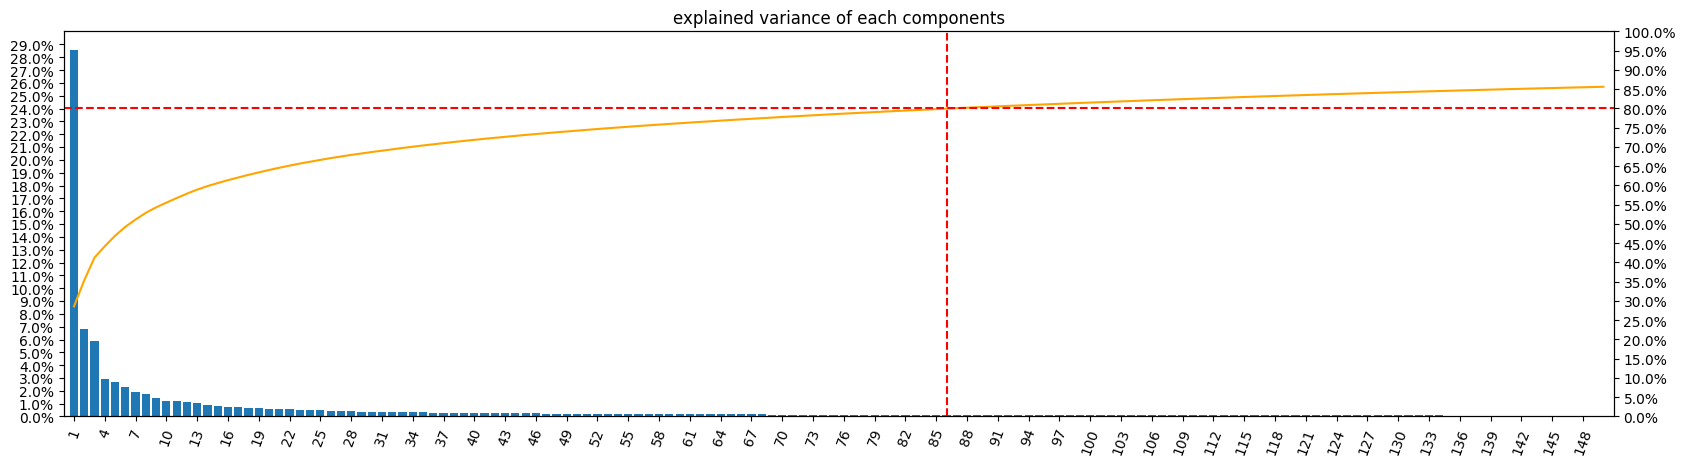

In [44]:
%time run_PCA_analysis(test_imgs, n_components, required_component_ratio, randomized = True);

The randomized PCA produced similar result to PCA. The number of components that are required to adequately represent the image data is 112.

#### 3.3 Comparison between PCA and Randomized PCA

### 4. Exceptional Work
#### 4.1 Overall Quality
The report is coherent, useful. and polished product. It make sense overall. The visualizations answered the questions in the Business Understanding. The sources are properly cited in the Reference section. Specific reasons for the assumptions are provided. Subsequent questions are followed naturally from initial exploration.
#### 4.2 Additional analysis

UMAP is one of dimension deduction methods. Compare to other techniques such as t-SNE, UMAP offers a number of advantages. Firstly, it's fast. On MINST dataset, UMAP can project the data less than 3 minutes, while t-SNE can take up to 45 minutes. Secondly, UMAP better preserve global structure of the data. This due to UMAP's strong theoretical foundations. Lastly, UMAP offers more understandable parameters that make it a more effective tool for visualizing high dimensional data.

UMAP starts by constructing a graph that captures relationships between data points. It then optimizes a low-dimensional representation that preserves these relationships, ensuring that nearby points in the high-dimensional space remain close in the reduced space. UMAP strikes a balance between preserving local structure, representing fine details, and maintaining global structure, capturing broader patterns.

Text(0.5, 0.92, 'Supervised UMAP Projection of the Stroke Data')

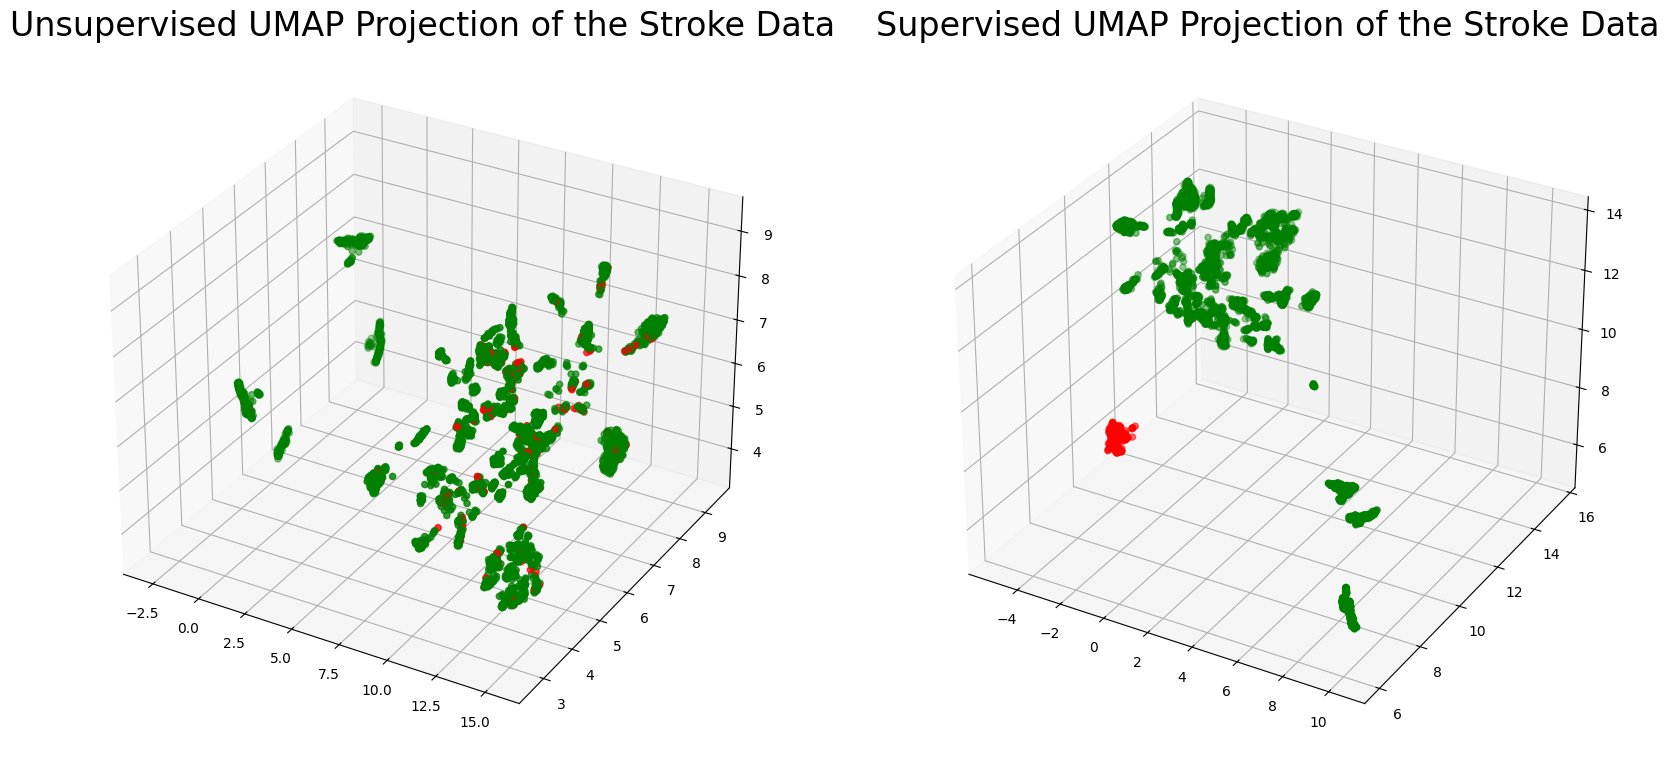

In [32]:
# UMAP dimension deduction
data_umap_unsupervised = umap.UMAP(n_components=3, n_neighbors=500).fit_transform(data_scaled)
data_umap_supervised = umap.UMAP(n_components=3, n_neighbors=500).fit_transform(data_scaled,  y = labels)

# plot the results
plot_colors = labels.map(lambda x: 'red' if x == 1 else 'green')

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(
    data_umap_unsupervised[:, 0],
    data_umap_unsupervised[:, 1],
    data_umap_unsupervised[:, 2],
    c=plot_colors)
plt.title('Unsupervised UMAP Projection of the Stroke Data', fontsize=24)

ax = fig.add_subplot(122, projection='3d')
ax.scatter(
    data_umap_supervised[:, 0],
    data_umap_supervised[:, 1],
    data_umap_supervised[:, 2],
    c=plot_colors)
plt.title('Supervised UMAP Projection of the Stroke Data', fontsize=24)

From the plots shown, the unsupervised UMAP failed to separate the dataset. In contrast, the supervised UMAP is able to separate the data into distinct clusters with data labels, despite that a small portion of stroke data is mixed with other data points.

References:

- Kaggle. Stroke Prediction Dataset. https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?resource=download (Accessed 2-04-2024)

- Center for Disease Control and Prevention. Stroke Facts. https://www.cdc.gov/stroke/facts.htm (Accessed 02-05-2024)

- Stroke Awareness Foundation. Stroke Risk Factors. https://www.strokeinfo.org/stroke-risk-factors/ (Accessed 02-05-2024)

- M.S. Pathan, et. al. "Identifying Stroke Indicators Using Rough Sets". https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9264165 (Accessed 02-05-2024)

- E.M. Alanazi, et. al. "Predicting Risk of Stroke From Lab Tests Using Machine Learning Algorithms: Development and Evaluation of Prediction Models" https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8686476/ (Accessed 02-05-2024)

- D. Zaric. Better Heatmaps and Correlation Matrix Plots in Python. https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec#:~:text=Let's%20start%20by%20making%20a,the%20larger%20the%20correlation%20magnitude. (Accessed 02-07-2024) 



